# Amortized LDA implementation

## Loading libraries

In [1]:
# Load libraries
import logging
import pyro

import pandas as pd

from zzz_utils import *
from zzz_utils_plot import *
from amortized_lda import *

import matplotlib.pyplot as plt

logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)

pyro.clear_param_store()
pyro.set_rng_seed(123)

## Amortized LDA graphical model

First we simulate a toy dataset to render the Pyro models.

In [3]:
nTopics = 3    # Topics
nCells = 10    # Cells
nRegions = 20 # Regions
N = [15] * nCells # Cells size

# Simulate data
obj = simulate_lda_dataset(nTopics = nTopics, nCells = nCells, 
                           nRegions = nRegions, N = N, 
                           a = torch.ones([nTopics]), b = torch.ones([nRegions]))
# transpose so it matches Pyro's input
D = torch.from_numpy(obj['D'].transpose())

Below we define the LDA model with Pyro. Note that data D is a matrix of nCounts x nCells, and here we assume that nCounts is the same across cells.

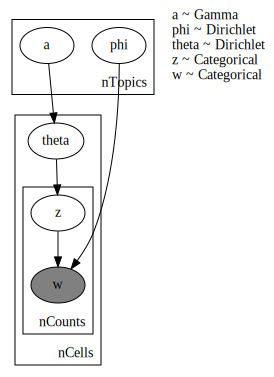

In [4]:
pyro.clear_param_store()
pyro.render_model(amortized_lda_model, model_args=(D, nTopics, nRegions), 
                  render_distributions=True, render_params=True)

## Amortized LDA guide (variational approximation)

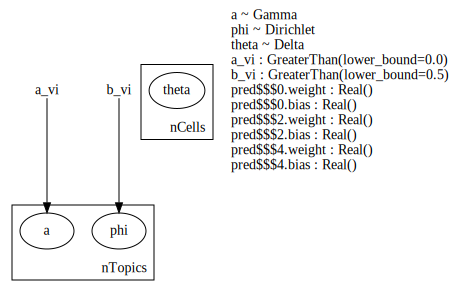

In [6]:
# Create NN predictor
layer_sizes = "100-100"
pred = nn_predictor(nTopics, nRegions, layer_sizes)
guide = functools.partial(amortized_lda_guide, pred)
pyro.render_model(guide, model_args=(D, nTopics, nRegions), 
                  render_distributions=True, render_params=True)

# Testing variational inference

## Simulate data
We use simulated data from the LDA model to test the amortized LDA inference performance. 
I.e. how close are inferred values to true values used to simulate the data. 

__Note__ there is the known identifiability issue of mixture and mixed-membership models, however we still would expect cell assignments to be consistent with the simulated data.


In [18]:
# Simulate data
nTopics = 2    # Topics
nCells = 1000    # Cells
nRegions = 300 # Regions
N = [100] * nCells # Cells size
a = torch.ones([nTopics]) * 1/5
b = torch.ones([nRegions]) * 1/10
# Simulate data
obj_sim = simulate_lda_dataset(nTopics = nTopics, nCells = nCells, 
                               nRegions = nRegions, N = N, 
                               a = a, b = b)
# Filter to keep only regions with decent coverage
det_thr = 0.05
obj_sim = qc_lda_simulation_object(obj = obj_sim, peak_detection_qc_thr = 0.05)

Number of peak regions passing QC threshold: 140
shape  of D after QC:             (1000, 100)
length of D_freq after QC:        1000
shape  of theta_true after QC:    torch.Size([1000, 2])
shape  of phi_true after QC:      torch.Size([2, 140])
shape  of phi_true_norm after QC: torch.Size([2, 140])


In [19]:
# transpose so it matches Pyro's input
D = torch.from_numpy(obj_sim['D'].transpose())
D.shape # simulated data dims nCounts x nCells

torch.Size([100, 1000])

In [20]:
obj_sim['theta_true'][1:10, ] # first 10 cells prob assignments to each topic

tensor([[7.3867e-02, 9.2613e-01],
        [1.2977e-02, 9.8702e-01],
        [2.9614e-07, 1.0000e+00],
        [9.4917e-01, 5.0830e-02],
        [4.2058e-05, 9.9996e-01],
        [4.2151e-03, 9.9578e-01],
        [9.9914e-01, 8.5823e-04],
        [9.9453e-01, 5.4682e-03],
        [4.5252e-02, 9.5475e-01]])

In [21]:
obj_sim['phi_true'][:, 1:10].transpose(0, 1) # first 10 region-topic probs

tensor([[2.1406e-02, 2.3592e-02],
        [6.3207e-03, 2.4520e-03],
        [1.3989e-03, 4.0846e-04],
        [7.1047e-03, 2.8329e-21],
        [8.9706e-09, 4.1681e-03],
        [1.4254e-02, 8.8305e-06],
        [1.5648e-07, 6.7963e-03],
        [3.4740e-03, 3.9034e-12],
        [1.8111e-05, 9.4624e-04]])

In [31]:
vocab = obj_sim['vocab']

## Fit AmortizedLDA 

To perform inference for Amortized LDA with use ClippedAdam to optimize a 
__trace implementation of ELBO-based SVI__ ('TraceEnum_ELBO'), which supports exhaustive enumeration 
over discrete sample sites, in our case latent topic assignment __z__.

In [23]:
nTopics = 2
nSteps = 1500
lr = 0.1
seed = 123

pyro.set_rng_seed(seed)
pyro.clear_param_store()

# We'll fit using SVI.
logging.info("-" * 40)
logging.info("Fitting {} cells".format(D.shape[1]))

# Create NN predictor
layer_sizes = "100-100"
pred = nn_predictor(nTopics, nRegions, layer_sizes)
guide = functools.partial(amortized_lda_guide, pred)
elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=2)
optim = pyro.optim.ClippedAdam({"lr": lr, 'weight_decay':0.01})
svi = pyro.infer.SVI(amortized_lda_model, guide, optim, elbo)
losses = []

logging.info("Step\tLoss")
for step in range(nSteps):
    loss = svi.step(D=D, nTopics=nTopics, nRegions=nRegions, batch_size=64)
    if step % 100 == 0:
        logging.info("{: >5d}\t{}".format(step, loss))
    losses.append(loss)
logging.info("final loss = {}".format(loss))

   503106 ----------------------------------------
   503106 Fitting 1000 cells
   503109 Step	Loss
   503186     0	581610.375
   505390   100	444941.0625
   507542   200	436286.875
   509755   300	437753.3125
   511967   400	437087.46875
   514286   500	436557.75
   516462   600	436355.375
   518635   700	438401.90625
   520886   800	435416.15625
   523259   900	435213.34375
   525501  1000	433706.4375
   527731  1100	433935.625
   529982  1200	434389.5
   532251  1300	433598.8125
   534607  1400	434496.96875
   537080 final loss = 435925.34375


Here we plot the ELBO loss during optimisation.

Text(0, 0.5, 'ELBO loss')

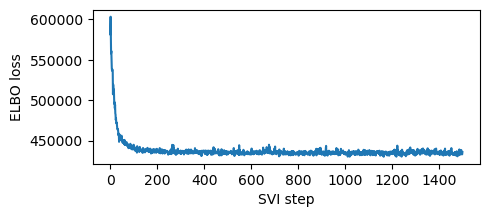

In [24]:
# plot ELBO losses
plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

## Assessing inferred parameters

Below we show estimates of the inferred model parameters. To show this, here I am just taking a sample from the 
posterior fit (i.e. calling the guide with the optimized set of variational parameters). Surely this is not the optimal way to summarise the posterior fit. 

__However__, if I take multiple samples from the posterior and subseqently summarise the posterior samples (e.g. by median), due to label switching that occurs when sampling 
$\theta \sim Dir(\alpha)$, the posterior mode will be useless. 

__TODO__ 

1. Define a better way to summarize the posterior distribution from posterior samples. E.g. by fixing the label switching problem, post-hoc after sampling from the posterior (similar approach to mixture models).
2. Make posterior predictive checks.
3. Need to understand Pyro's `poutine`.


In [35]:
# A single sample from the guide
post_sample = guide(D = D, nTopics = nTopics, nRegions = nRegions)

In [36]:
post_sample['alpha'] # posterior alpha

tensor([ 81.3534, 238.3525], grad_fn=<DivBackward0>)

In [37]:
obj_sim['theta_true'][1:10, ] # first 10 cells prob assignments to each topic

tensor([[7.3867e-02, 9.2613e-01],
        [1.2977e-02, 9.8702e-01],
        [2.9614e-07, 1.0000e+00],
        [9.4917e-01, 5.0830e-02],
        [4.2058e-05, 9.9996e-01],
        [4.2151e-03, 9.9578e-01],
        [9.9914e-01, 8.5823e-04],
        [9.9453e-01, 5.4682e-03],
        [4.5252e-02, 9.5475e-01]])

In [38]:
post_sample['theta'][1:10, :] # posterior theta

tensor([[0.2689, 0.7311],
        [0.2689, 0.7311],
        [0.2689, 0.7311],
        [0.2689, 0.7311],
        [0.2689, 0.7311],
        [0.2689, 0.7311],
        [0.2689, 0.7311],
        [0.2689, 0.7311],
        [0.2689, 0.7311]], grad_fn=<SliceBackward0>)

In [39]:
post_sample['phi'][:, 1:10].detach().numpy().transpose() # posterior phi

array([[4.8994604e-02, 1.1892575e-02],
       [6.5729767e-03, 2.8518043e-03],
       [8.5009600e-04, 6.5409456e-04],
       [2.5457055e-03, 3.6846073e-03],
       [3.7133452e-04, 2.5613757e-03],
       [7.8267334e-03, 7.7146715e-03],
       [2.1746831e-05, 4.0794695e-03],
       [3.6698333e-03, 1.6227536e-03],
       [1.1804155e-03, 4.3870759e-04]], dtype=float32)

### Worldclouds

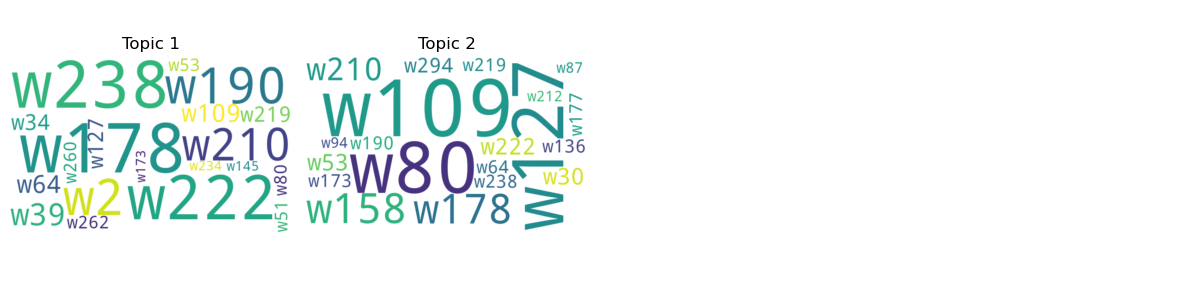

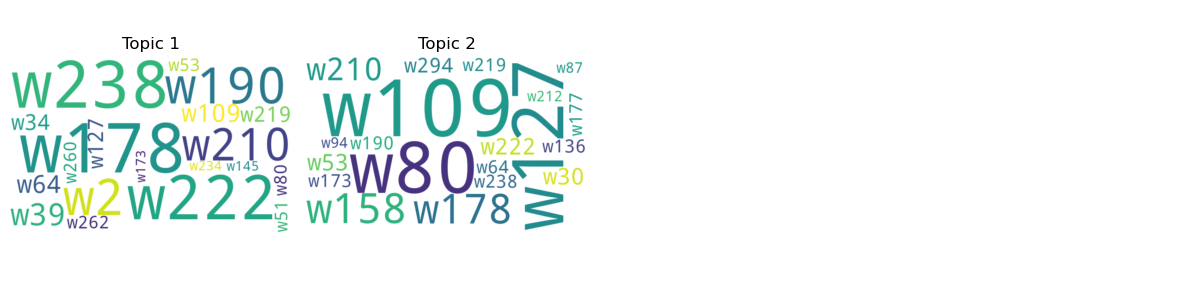

In [40]:
make_word_cloud_figure(post_sample['phi'], vocab, 20)

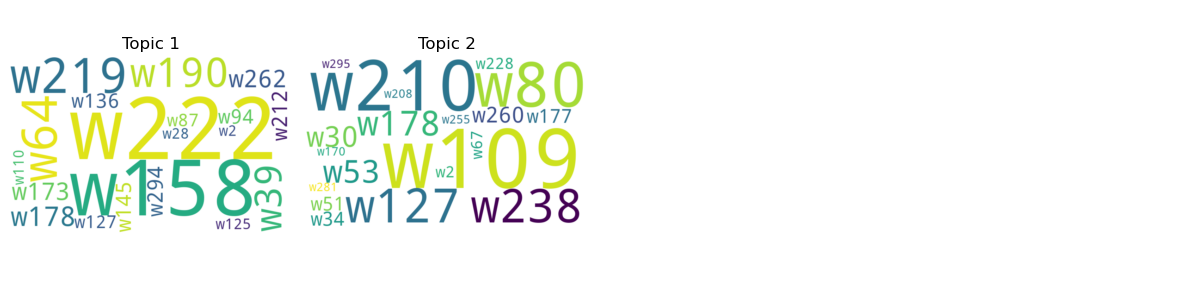

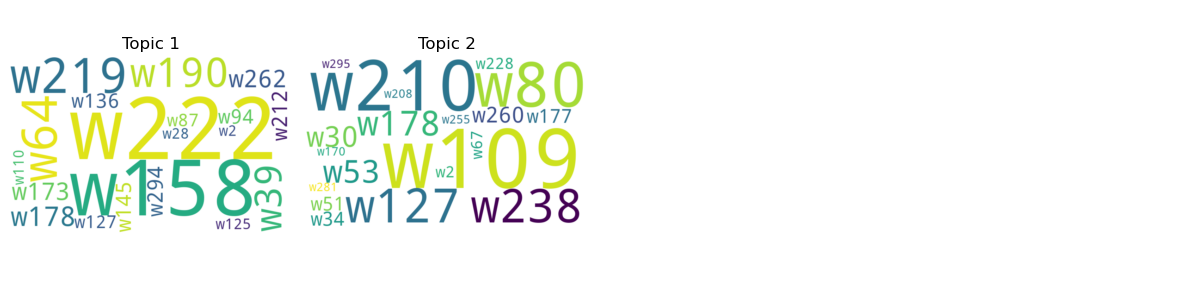

In [41]:
make_word_cloud_figure(obj_sim['phi_true'], vocab, 20)

### Topic-cell distribution plots

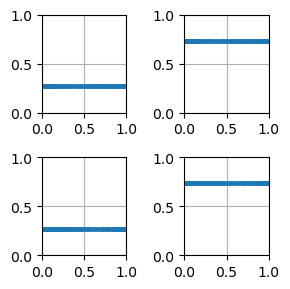

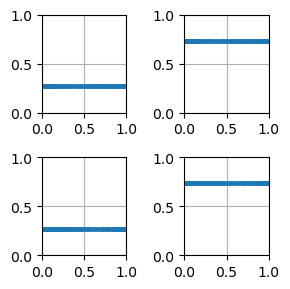

In [42]:
make_theta_comparison_plots(theta_true = obj_sim['theta_true'], 
                            theta_infer = post_sample['theta'].detach().numpy())